<a href="https://colab.research.google.com/github/BhavanaLalwani/Text-Sentiment-Analysis/blob/master/ECE542_ProjectF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble
This part is just performing the imports and defining the utility functions required for the project.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Upgrade TensorFlow and Keras
# !pip install --upgrade tensorflow
# !pip install --upgrade keras
# !pip install nltk
# !pip install gensim

# Standard imports
import numpy as np
import csv
import argparse
import os
import json
import random
import math
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
import sklearn

# Keras imports
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, GlobalMaxPooling1D
from keras.initializers import Constant
from keras import backend as K
import keras

BASE_DIR = 'drive/My Drive/ECE542-ProjectF/'
DATA_DIR = BASE_DIR + 'data/'

GLOVE_DIR = DATA_DIR + 'GloVe'
ISEAR_PATH = DATA_DIR + 'isear/isear_clean.csv'
W2V_PATH = DATA_DIR + 'w2v/GoogleNews-vectors-negative300.bin'
CANDIDATE = BASE_DIR + 'candidate_model.h5'

# TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 200
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300

ISEAR_SHUFFLE_SEED = 62
KAGGLE_SHUFFLE_SEED = 43

ISEAR_TEST_SPLIT = 0.1
ISEAR_VALIDATION_SPLIT = 0.1
KAGGLE_VALIDATION_SPLIT = 0.2

EMBEDDING_TYPE = 'GloVe'


In [0]:
def split_data(data, labels, val_split, test_split, seed):
  # Shuffle our dataset. Using a known seed allows us to get the same result 
  # each time we run the script.
  indices = np.arange(data.shape[0])
  random.Random(seed).shuffle(indices)

  data = data[indices]
  labels = labels[indices]

  # Determine number of samples in train/val/test
  num_val = math.floor(data.shape[0] * val_split)
  num_test = math.floor(data.shape[0] * test_split)

  # Split the data into the test, val, and train subsets.
  x_test = data[:num_test]
  y_test = labels[:num_test]

  x_val = data[num_test:num_val + num_test]
  y_val = labels[num_test:num_val + num_test]

  x_train = data[num_val + num_test:]
  y_train = labels[num_val + num_test:]

  # Return a dictionary of the data with train/val/test and x/y.
  return {
      'train': {
          'x': x_train, 'y': y_train
      },
      'val': {
          'x': x_val, 'y': y_val
      },
      'test': {
          'x': x_test, 'y': y_test
      }
  }

# Define custom metrics for model performance during training.
def prec_m(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    pp = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (pp + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    pp = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = tp / (pp + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = prec_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision + recall + K.epsilon()))

# Create function for learning rate
def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.5
   epochs_drop = 5.0
   lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch)/epochs_drop))
   return lrate

# Preprocessing

In [0]:
# Load the ISEAR and Kaggle datasets and Tokenize the datasets
# Both datasets have the label as their first index and the text as their second

isear_text_data = []
isear_labels = []
kaggle_text_data = []
kaggle_labels = []

with open((ISEAR_PATH), 'r') as f:
  reader = csv.reader(f)
  for row in reader:
    isear_text_data.append(row[1])
    isear_labels.append(int(row[0]))

In [0]:
## Tokenize ISEAR

# ISEAR
isear_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
isear_tokenizer.fit_on_texts(isear_text_data)
isear_seq = isear_tokenizer.texts_to_sequences(isear_text_data)
isear_index = isear_tokenizer.word_index
isear_data = pad_sequences(isear_seq, maxlen=MAX_SEQUENCE_LENGTH)
isear_labels = to_categorical(isear_labels)

# Shuffle our dataset. Using a known seed allows us to get the same result 
# each time we run the script.
isear_split = split_data(
    isear_data, 
    isear_labels, 
    ISEAR_VALIDATION_SPLIT, 
    ISEAR_TEST_SPLIT, 
    ISEAR_SHUFFLE_SEED
  )

## Create Embeddings

In [0]:
## Prepare the Embedding matrix

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.{0:d}d.txt'.format(EMBEDDING_DIM))) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found {0:d} word vectors.'.format(len(embeddings_index)))

isear_embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in isear_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        isear_embedding_matrix[i] = embedding_vector


Found 400000 word vectors.


In [0]:
from gensim.models import KeyedVectors

model_w2v = KeyedVectors.load_word2vec_format(W2V_PATH, binary=False)
w2v_index = {}
for word in model_w2v.wv.vocab.keys():
  w2v_index[word] = model_w2v.wv[word]

w2v_embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in isear_index.items():

  if i >= MAX_NUM_WORDS:
    continue

  embedding_vector = embedding_idx.get(word)
  if embedding_vector is not None:
    # Embedding not found
    w2v_embedding_matrix[i] = embedding_vector


# Model Definition

In [0]:
def NLPModel(embedding_matrix, num_classes, bidirectional=True,
             mode='parallel', optimizer=None, rnn_size=128, rnn_type='lstm', 
             embedding_trainable=True, max_seq_len=MAX_SEQUENCE_LENGTH,
             max_num_words=MAX_NUM_WORDS, embedding_dim=EMBEDDING_DIM):
    
    seq_input = Input(shape=(max_seq_len,))
    x = Embedding(
        max_num_words,
        embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_seq_len,
        trainable=embedding_trainable
    )(seq_input)
    x = Dropout(0.25)(x)


    ## Deep Layers
    # Convolutional layer
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = Conv1D(256, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(5)(x)

    if rnn_type == 'gru':
        # Recurrent Layer
        if mode == 'parallel':
            if bidirectional:
                gru_x = Bidirectional(GRU(rnn_size))(x)
                gru_y = Bidirectional(GRU(rnn_size))(x)
            else:
                gru_x = GRU(rnn_size)(x)
                gru_y = GRU(rnn_size)(x)

            x = concatenate([gru_x, gru_y])

        elif mode == 'stack':
            if bidirectional:
                x = Bidirectional(GRU(rnn_size, return_sequences=True))(x)
                x = Bidirectional(GRU(rnn_size))(x)
            else:
                x = GRU(rnn_size, return_sequences=True)(x)
                x = GRU(rnn_size)(x)
        else:
            if bidirectional:
                x = Bidirectional(GRU(rnn_size))(x)
            else:
                x = GRU(rnn_size)(x)
    else:
        if mode == 'parallel':
            if bidirectional:
                lstm_x = Bidirectional(LSTM(rnn_size))(x)
                lstm_y = Bidirectional(LSTM(rnn_size))(x)
            else:
                lstm_x = LSTM(rnn_size)(x)
                lstm_y = LSTM(rnn_size)(x)

            x = concatenate([lstm_x, lstm_y])
        elif mode == 'stack':
            if bidirectional:
                x = Bidirectional(LSTM(rnn_size, return_sequences=True))(x)
                x = Bidirectional(LSTM(rnn_size))(x)
            else:
                x = LSTM(rnn_size, return_sequences=True)(x)
                x = LSTM(rnn_size)(x)
        else:
            if bidirectional:
                x = Bidirectional(LSTM(rnn_size))(x)
            else:
                x = LSTM(rnn_size)(x)

    x = Dropout(0.5)(x)

    # Predictive Layer
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)

    if num_classes > 2:
        pred = Dense(num_classes, activation='softmax')(x)
        loss = 'categorical_crossentropy'
    else:
        pred = Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'

    if optimizer is None:
        opt = keras.optimizers.Adam(learning_rate=1e-3)
    else:
        opt = optimizer

    model = Model(inputs=[seq_input], outputs=[pred])
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=['acc', f1_m, prec_m, recall_m]
    )

    return model

# Model Training

In [0]:
# Create the model
if EMBEDDING_TYPE == 'GloVe':
  embed_mat = isear_embedding_matrix
elif EMBEDDING_TYPE == 'Word2Vec':
  embed_mat = w2v_embedding_matrix

model = NLPModel(
    embed_mat,
    7,
    bidirectional=True,
    mode='stack',
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    rnn_size=128,
    rnn_type='lstm',
    embedding_trainable=False,
    max_seq_len=MAX_SEQUENCE_LENGTH,
    max_num_words=MAX_NUM_WORDS,
    embedding_dim=EMBEDDING_DIM
)

history = model.fit(
    isear_split['train']['x'], isear_split['train']['y'],
    batch_size=16,
    epochs=5,
    validation_data = (isear_split['val']['x'], isear_split['val']['y']),
    callbacks=[
      keras.callbacks.ModelCheckpoint(filepath='candidate.h5', monitor='val_loss', save_best_only=True)
    ]
)

# Plot history curves.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model on the test data
labels = isear_split['test']['y']
y_pred = []

predictions = model.predict(isear_split['test']['x'])
for pred in predictions:
  pred_oh = np.argmax(pred)
  y_pred.append(pred_oh)

text_labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

y_true = [np.argmax(label) for label in labels]
y_pred = [np.argmax(pred) for pred in predictions]

report = classification_report(y_true, y_pred, digits=3)
print(report)
print('Precision: {0:0.3f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Recall: {0:0.3f}'.format(recall_score(y_true, y_pred, average='macro')))

acc = sklearn.metrics.accuracy_score(y_true, y_pred)
f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

ax = sns.heatmap(conf_matrix, annot=conf_matrix, fmt='0.2f',
  xticklabels=text_labels, yticklabels=text_labels,
  cmap='Blues'
)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.savefig('ConfusionMatrix.png')
plt.show()


# Hyperparameter Tuning

## Learning Rate Selection

Testing Adam Learning Rate: 1e-03


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5975 samples, validate on 746 samples
Epoch 1/1
5975/5975 [==============================] - 15s 3ms/step - loss: 1.9477 - acc: 0.1572 - f1_m: 0.0000e+00 - prec_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9439 - val_acc: 0.1635 - val_f1_m: 0.0000e+00 - val_prec_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Testing Adam Learning Rate: 1e-02
Train on 5975 samples, validate on 746 samples
Epoch 1/1
5975/5975 [==============================] - 15s 3ms/step - loss: 1.9482 - acc: 0.1598 - f1_m: 0.0000e+00 - prec_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9316 - val_acc: 0.1716 - val_f1_m: 0.0000e+00 - val_prec_m: 0.0000e+00 - val_recall_m: 0.0000e+00


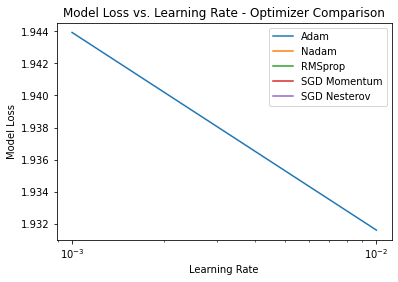

In [0]:
# Determine the best learning rate parameters

lr_history = {
  'Adam': {'x': [], 'y': [], 'loss': []},
  'Nadam': {'x': [], 'y': [], 'loss': []},
  'RMSprop': {'x': [], 'y': [], 'loss': []},
  'SGD Momentum': {'x': [], 'y': [], 'loss': []},
  'SGD Nesterov': {'x': [], 'y': [], 'loss': []}
}

lr_rates = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 
            1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1]

# Iterate over each learning rate. This allows us to specify the learning
# rate while constructing the optimizer.
for rate in lr_rates:
  
  # Map the string name with optimizer code
  opt_map = {
    'Adam': keras.optimizers.Adam(lr=rate),
    'Nadam': keras.optimizers.Nadam(lr=rate),
    'RMSprop': keras.optimizers.RMSprop(lr=rate),
    'SGD Momentum': keras.optimizers.SGD(lr=rate, momentum=0.9, nesterov=True),
    'SGD Nesterov': keras.optimizers.SGD(lr=rate, momentum=0.9, nesterov=False)
  }

  # Iterate over all optimizers and train the model.
  for opt_name, optimizer in opt_map.items():

    # Run the model and train it
    model = model = NLPModel(
      isear_embedding_matrix,
      7,
      bidirectional=True,
      mode='stack',
      optimizer=keras.optimizers.Adam(lr=1e-3),
      rnn_size=128,
      rnn_type='lstm',
      embedding_trainable=True,
      max_seq_len=MAX_SEQUENCE_LENGTH,
      max_num_words=MAX_NUM_WORDS,
      embedding_dim=EMBEDDING_DIM
    )

    # Fit the model.
    print('Testing {0:s} Learning Rate: {1:0.0e}'.format(opt_name, rate))
    history = model.fit(
      isear_split['train']['x'], isear_split['train']['y'],
      batch_size=128,
      epochs=1,
      validation_data=(isear_split['val']['x'], isear_split['val']['y'])
    )

    # Append data for optimizer
    lr_history[opt_name]['x'].append(rate)
    lr_history[opt_name]['y'].append(min(history.history['val_loss']))
    lr_history[opt_name]['loss'].append(history.history['val_loss'])

with open('lr_history.json', 'w') as f:
  f.write(json.dumps(lr_history, indent=2))

# Plot the results. Use a semilogx axis since the learning rate increases in
# magnitude logarithmically.
labels = []
for opt, data in lr_history.items():
  labels.append(opt)
  plt.semilogx(data['x'], data['y'])

# plt.grid()
plt.xlabel('Learning Rate')
plt.ylabel('Model Loss')
plt.title('Model Loss vs. Learning Rate - Optimizer Comparison')
plt.legend(labels)
plt.show()

## Batch Size Selection

In [0]:
# Batch size optimization

batch_history = {}
# Iterate over specified batch sizes
batch_sizes = [8, 16, 32, 64, 128]
for batch_size in batch_sizes:

  # Run the model and train it
  model = NLPModel(
      isear_embedding_matrix,
      7,
      bidirectional=True,
      mode='stack',
      optimizer=keras.optimizers.Adam(lr=1e-3),
      rnn_size=128,
      rnn_type='lstm',
      embedding_trainable=True,
      max_seq_len=MAX_SEQUENCE_LENGTH,
      max_num_words=MAX_NUM_WORDS,
      embedding_dim=EMBEDDING_DIM
    )

  print('Testing Batch Size: {0:d}'.format(batch_size))
  history = model.fit(
    isear_split['train']['x'], isear_split['train']['y'],
    batch_size=batch_size,
    epochs=15,
    validation_data=(isear_split['val']['x'], isear_split['val']['y'])
  )

  # Append data for optimizer
  batch_str = str(batch_size)
  batch_history[batch_str] = {'x': [], 'y': [], 'loss': []}
  batch_history[batch_str]['x'].append([x + 1 for x in range(epochs)])
  batch_history[batch_str]['y'].append(min(history.history['val_loss']))
  batch_history[batch_str]['loss'].append(history.history['val_loss'])

# Save data to file
with open('batch_history.json', 'w') as f:
  f.write(json.dumps(batch_history, indent=2))

# Plot the results
labels = []
for bsize, data in batch_history.items():
  labels.append('Batch size {0:s}'.format(bsize))
  plt.plot(data['x'], data['y'])

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validtion Loss vs. Epoch - Batch Size Comparison')
plt.legend(labels)
plt.show()

## Model Variant Selection
This section iterates and varies the RNN architecture as well as the embedding layer to determine the best architecture configuration.

In [0]:
results = {}
for embed_train in [False, True]:
  for rnn_type in ['lstm', 'gru']:
    for bidirectional in [False, True]:
      for embedding_name in ['GloVe', 'W2V']:
        
        if embedding_name == 'GloVe':
          embedding_mat = isear_embedding_matrix
        else:
          embedding_mat = w2v_embedding_matrix

        print('Now training: {1:s}{0:s} {2:s}'.format(
            rnn_type.upper(),
            'Bi' if bidirectional else '',
            'Unfrozen' if embed_train else 'Frozen'
        ))
        model = NLPModel(
            embedding_mat,
            7,
            bidirectional=True,
            mode='stack',
            optimizer=keras.optimizers.Adam(lr=1e-3),
            rnn_size=128,
            rnn_type=rnn_type,
            embedding_trainable=embed_train,
            max_seq_len=MAX_SEQUENCE_LENGTH,
            max_num_words=MAX_NUM_WORDS,
            embedding_dim=EMBEDDING_DIM
        )

        history = model.fit(
            isear_split['train']['x'], isear_split['train']['y'],
            batch_size=16,
            epochs=20,
            validation_data=(isear_split['val']['x'], isear_split['val']['y'])
        )

        # Get epoch that had lowest validation loss.
        min_val_idx = history.history['val_loss'].index(min(history.history['val_loss']))

        # Record the F1 and accuracy of that epoch in results.
        cfg_name = '{0:s}_{1:s}{2:s}_{3:s}'.format(
            embedding_name,
            'Bi' if bidirectional else '',
            rnn_type.upper(),
            'Unfrozen' if embed_train else 'Frozen'
        )

        results[cfg_name] = {
            'Accuracy': history.history['val_acc'][min_val_idx],
            'F1M': history.history['val_f1m'][min_val_idx]
        }

In [0]:
# Plot the results of the trainings in a matrix.
f1 = np.zeros((4,4))
acc = np.zeros((4,4))
f1_annot = np.chararray((4,4), itemsize=5)
labels = np.chararray((4,4), itemsize=21)
for i, row in enumerate(f1):
  for j, col in enumerate(row):

    rnn_type = 'LSTM' if i < 2 else 'GRU'
    bidir_type = 'Bi' if i % 2 != 0 else ''
    train_set = 'GloVe' if j < 2 else 'W2V'
    train_type = 'Frozen' if j % 2 == 0 else 'Unfrozen'

    rnn_text = bidir_type + rnn_type
    name = train_set + '_' + rnn_text + '_' + train_type

    labels[i][j] = name
    f1[i][j] = results[name]['candidate_model.h5']['F1M']
    # print(type(results[name]['candidate_model.h5']['F1M']))
    # print(type(f1[i][j]))
    f1_annot[i][j] = f1[i][j]
    acc[i][j] = results[name]['candidate_model.h5']['Accuracy']

ax = sns.heatmap(f1, annot=f1 ,cmap='Blues', fmt='0.3f',
yticklabels=['LSTM', 'BiLSTM', 'GRU', 'BiGRU'],
xticklabels=['GloVe F', 'GloVe UF', 'W2V F', 'W2V UF'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Model F1 Scores')
plt.show()

# Sample Inputs with Candidate Model

[0.016790548339486122, 0.010621024295687675, 0.017902549356222153, 0.025814641267061234, 0.4609393775463104, 0.45469117164611816, 0.013240624219179153]


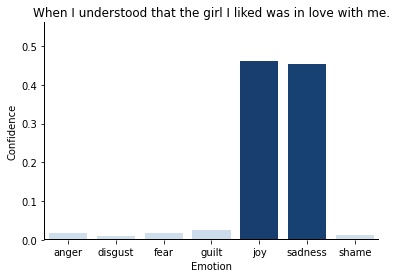

In [0]:

def translate(vals, left, right):
    return ((vals / max(vals)) * (right - left)) + left

input_text = 'When I understood that the girl I liked was in love with me.'
text_labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

seq = isear_tokenizer.texts_to_sequences([input_text])
data = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

model = load_model(CANDIDATE,
  custom_objects={
    'f1_m': f1_m,
    'recall_m': recall_m,
    'prec_m': prec_m
})


pred = model.predict(data)
pred = pred.flatten().tolist()
print(pred)

df_data = {
    'Confidence': pred,
    'Emotion': text_labels
}
df = pd.DataFrame(data=df_data)

fig = plt.figure()
ax = plt.axes(frameon=False)

# Turn off frame. Turn off y axis.
ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(True)


v = df.Confidence
v = translate(v, 0.2, 0.95)
colors = matplotlib.cm.Blues(v)

ax = sns.barplot(x='Emotion', y='Confidence', data=df, 
palette=colors
)
# ax.bar(text_labels, ydata)
ax.set_ylim((0, max(pred) + 0.1))
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=1))

ax.set_facecolor('white')
ax.set_xlabel('Emotion')
ax.set_ylabel('Confidence')
ax.set_title(input_text)
plt.show()

# Evaluate  Candidate

              precision    recall  f1-score   support

           0      0.527     0.616     0.568       112
           1      0.776     0.590     0.670       100
           2      0.693     0.725     0.709       109
           3      0.471     0.554     0.509       101
           4      0.753     0.700     0.725       100
           5      0.581     0.626     0.603       115
           6      0.517     0.422     0.465       109

    accuracy                          0.605       746
   macro avg      0.617     0.605     0.607       746
weighted avg      0.614     0.605     0.606       746

Precision: 0.617
Recall: 0.605


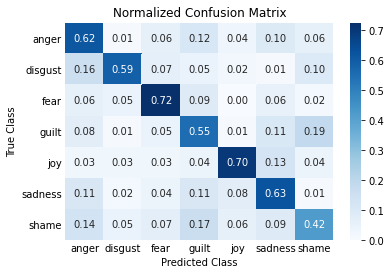

In [0]:
model = load_model(
    CANDIDATE,
    custom_objects={
        'f1_m': f1_m,
        'recall_m': recall_m,
        'prec_m': prec_m
  })

# Evaluate the model on the test data
labels = isear_split['test']['y']
y_pred = []

predictions = model.predict(isear_split['test']['x'])
for pred in predictions:
  pred_oh = np.argmax(pred)
  y_pred.append(pred_oh)

text_labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

y_true = [np.argmax(label) for label in labels]
y_pred = [np.argmax(pred) for pred in predictions]

report = classification_report(y_true, y_pred, digits=3)
print(report)
print('Precision: {0:0.3f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Recall: {0:0.3f}'.format(recall_score(y_true, y_pred, average='macro')))

acc = sklearn.metrics.accuracy_score(y_true, y_pred)
f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

ax = sns.heatmap(conf_matrix, annot=conf_matrix, fmt='0.2f',
  xticklabels=text_labels, yticklabels=text_labels,
  cmap='Blues'
)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.savefig('ConfusionMatrix.png')
plt.show()
